In [20]:
# coding: utf-8

import numpy as np
import pandas as pd

from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Activation,Concatenate, Lambda, GaussianNoise
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
import tensorflow_addons as tfa
import datatable as dt
from tqdm import tqdm
from random import choices

## Data Loading

In [23]:
#  Init Random seed
SEED = 1111
np.random.seed(SEED)
tf.random.set_seed(SEED)

print('Loading data...')

train_datatable = dt.fread('../input/jane-street-market-prediction/train.csv')  # datatable perform better
train = train_datatable.to_pandas()
del train_datatable
display(train)

Loading data...


,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,...,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id
0,0,0.000000,0.009916,0.014079,0.008773,0.001390,0.006270,1,-1.872746,-2.191242,...,NaN,1.168391,8.313583,1.782433,14.018213,2.653056,12.600292,2.301488,11.445807,0
1,0,16.673515,-0.002828,-0.003226,-0.007319,-0.011114,-0.009792,-1,-1.349537,-1.704709,...,NaN,-1.178850,1.777472,-0.915458,2.831612,-1.417010,2.297459,-1.304614,1.898684,1
2,0,0.000000,0.025134,0.027607,0.033406,0.034380,0.023970,-1,0.812780,-0.256156,...,NaN,6.115747,9.667908,5.542871,11.671595,7.281757,10.060014,6.638248,9.427299,2
3,0,0.000000,-0.004730,-0.003273,-0.000461,-0.000476,-0.003200,-1,1.174378,0.344640,...,NaN,2.838853,0.499251,3.033732,1.513488,4.397532,1.266037,3.856384,1.013469,3
4,0,0.138531,0.001252,0.002165,-0.001215,-0.006219,-0.002604,1,-3.172026,-3.093182,...,NaN,0.344850,4.101145,0.614252,6.623456,0.800129,5.233243,0.362636,3.926633,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2390486,499,0.000000,0.000142,0.000142,0.005829,0.020342,0.015396,1,-1.649365,-1.169996,...,-1.896874,-1.260055,1.947725,-1.994399,-1.685163,-2.866165,-0.216130,-1.892048,0.901585,2390486
2390487,499,0.000000,0.000012,0.000012,-0.000935,-0.006326,-0.004718,1,2.432943,5.284504,...,-0.936553,1.064936,3.119762,-0.419796,-0.208975,-0.146749,0.730166,0.648452,2.068737,2390487
2390488,499,0.000000,0.000499,0.000499,0.007605,0.024907,0.016591,1,-0.622475,-0.963682,...,-2.956745,-0.640334,-2.279663,-0.950259,-4.388417,-1.669922,-3.288939,-1.336142,-2.814239,2390488
2390489,499,0.283405,-0.000156,-0.000156,-0.001375,-0.003702,-0.002004,-1,-1.463757,-1.107228,...,-2.035894,-1.780962,0.881246,-2.202140,-1.912601,-3.341684,-0.571188,-2.185795,0.627452,2390489


## Preprocess Data

In [24]:
print('Data preprocessing...')

train = train.query('date > 85').reset_index(drop = True)   # Remove the first 85th date due to the abnormal behavior from the laters
train = train[train['weight'] != 0]

train.fillna(train.mean(),inplace=True)  # try expanding mean later

print(f"Train Share{train.shape}")
print('Done!')

Data preprocessing...
Train Share(1571415, 138)
Done!


## Normalization

In [25]:
# z-score
# Pre-calc the features' mean and std for using in prediction
print('Normalization...')

features_mean = train.loc[:, train.columns.str.contains('feature')].mean()
features_std  = train.loc[:, train.columns.str.contains('feature')].std()
train_features_normorlization = (train.loc[:, train.columns.str.contains('feature')] - features_mean) / features_std

print('【train_features_normorlization】【features_mean】【features_std】Done!')

Normalization...
【train_features_normorlization】【features_mean】【features_std】Done!


## One Hot

In [26]:
from sklearn.preprocessing import OneHotEncoder
print('one-hot...')

# feature0: Action Assumed
f0_onehot_encoder = OneHotEncoder()
print('fitting...', end='')
f0_onehot_encoder.fit(train[['feature_0']])
print('Done!\ntransforming...', end='')
f0_onehot = f0_onehot_encoder.transform(train[['feature_0']]).toarray()
print('Feature0(Action) one-hot Done!')

one-hot...
fitting...Done!
transforming...Feature0(Action) one-hot Done!


## Data Featuring

In [28]:
# f41_f42_f43 = stock_id    
# stock_id
train['stock_id'] = train['feature_41'] + train['feature_42'] + train['feature_43']  
# train set has 27w stock-id(may be not id due to no such many stock available)
# Bucket the id frequency
stock_counts_bin = pd.DataFrame({
    'stock_id':train['stock_id'].values,
    'stock_counts_bin':pd.qcut(train['stock_id'].rank(method='first'), 20, labels=False)  # 等频20桶
})

stock_id_onehot_encoder = OneHotEncoder(handle_unknown='ignore')
print('fitting...', end='')
stock_id_onehot_encoder.fit(stock_counts_bin[['stock_counts_bin']])
print('Done!\ntransforming...')
stock_id_onehot = stock_id_onehot_encoder.transform(stock_counts_bin[['stock_counts_bin']]).toarray()

print(stock_id_onehot[-1])
print(stock_id_onehot.shape)
display(stock_counts_bin)

print('【stock_id_onehot】Done!')

fitting...Done!
transforming...
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1571415, 20)


,stock_id,stock_counts_bin
0,-1.702478,5
2,-3.338676,1
3,2.698305,14
6,-2.851470,2
7,4.817601,16
...,...,...
1862550,3.442952,15
1862552,7.669046,18
1862584,-0.944197,7
1862587,2.742807,14


【stock_id_onehot】Done!


## Featuring....
1. Data features original
2. f0：action onehot
3. f41+f42+f43: stock_idonehot
4. explore the feature and tag relationship

In [30]:
print('Merge and drop features...')
# train_nparray = train.loc[:, train.columns.str.contains('feature')].drop(['feature_0','feature_41','feature_42','feature_43'], axis=1).values
# remove feature0
train_nparray = np.delete(train_features_normorlization.values, [0,], axis=1)

# print(train_nparray.shape)
# print(f0_onehot.shape)
# print(stock_id_onehot.shape)
# print(np.concatenate([train_nparray, f0_onehot, stock_id_onehot],axis=1).shape)

print('【train_nparray】Done!')

Merge and drop features...
【train_nparray】Done!


## Y, X Defination

In [31]:
print('Define X and y...')

X_train = np.concatenate([train_nparray, f0_onehot],axis=1)
resp_cols = ['resp_1', 'resp_2', 'resp_3', 'resp', 'resp_4']
y_train = np.stack([(train[c] > 0).astype('int') for c in resp_cols]).T

# print(X_train[0])
del train, train_nparray, f0_onehot, stock_id_onehot, train_features_normorlization

print('【X_train】【y_train】Done!')

Define X and y...
【X_train】【y_train】Done!


## Model Defination

In [32]:
print('Create a easy NN model...')

HIDDEN_LAYER = [160, 160, 160]
TARGET_NUM = 5   # 5 resp output

# np.set_printoptions(threshold=1000)
# print(X_train[0])

input = tf.keras.layers.Input(shape=(X_train.shape[1], ))

x = tf.keras.layers.BatchNormalization()(input)
x = tf.keras.layers.Dropout(0.2)(x)
for units in HIDDEN_LAYER:
    x = tf.keras.layers.Dense(units)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)  # ReLU and others activations and model ensebler
    x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(TARGET_NUM)(x)

output = tf.keras.layers.Activation("sigmoid")(x)

model = tf.keras.models.Model(inputs=input, outputs=output)
model.compile(
    optimizer = tfa.optimizers.RectifiedAdam(learning_rate=1e-3),
    metrics   = tf.keras.metrics.AUC(name="AUC"),
    loss      = tf.keras.losses.BinaryCrossentropy(label_smoothing=1e-2),
)

print('Done!')

Create a easy NN model...
Done!


## Model Training

In [ ]:
print('Training Model...')

history = model.fit(X_train, y_train, epochs=100, batch_size=4096)
models = []
models.append(model)

print('Done!')

Train NN...
Epoch 1/100
 71/384 [====>.........................] - ETA: 24s - loss: 0.7734 - AUC: 0.5010

## Learning Curve 

See what is the Learning Curve looks like...


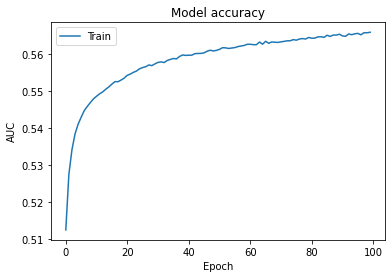

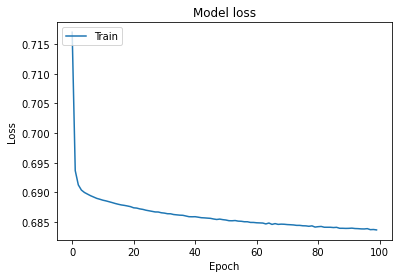

In [16]:
print('See what is the Learning Curve looks like...')
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['AUC'])
#plt.plot(history.history['val_AUC'])
plt.title('Model accuracy')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Loss plot
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## clean work

In [17]:
del X_train, y_train

## Prediction

In [18]:
THRESHOLD = 0.501

import janestreet
from tqdm import tqdm
janestreet.make_env.__called__ = False
env = janestreet.make_env()


for (test_df, pred_df) in tqdm(env.iter_test()):
    if test_df['weight'].item() > 0:
        
        test_features_nparray = test_df.loc[:, test_df.columns.str.contains('feature')].values  
        
        # replace NaN with train set mean
        if np.isnan(test_features_nparray.sum()):         
            test_features_nparray = np.nan_to_num(test_features_nparray) + np.isnan(test_features_nparray) * features_mean.values
        
        # Normalization
        test_features_nparray = (test_features_nparray[0] - features_mean.values) / features_std.values
        
        # one-hot：action
        test_f0_onehot_nparray = f0_onehot_encoder.transform(test_df[['feature_0']]).toarray()
        
        
        # drop and merge
        test_features_nparray = np.delete([test_features_nparray], [0,], axis=1)
        test_features_nparray = np.concatenate([test_features_nparray, test_f0_onehot_nparray],axis=1)
        
        pred = model(test_features_nparray, training = False).numpy()
        
       
        # Prediction average
        pred = np.mean(pred)
        
        
        pred_df.action = np.where(pred >= THRESHOLD, 1, 0).astype(int)
    else:
        pred_df.action = 0
    env.predict(pred_df)

15219it [03:28, 72.91it/s] 
